In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# Importing the Keras libraries and other packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime
import pandas as pd
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras.models import load_model


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
classifier = Sequential()

### **Convolution**

In [ ]:
# 1. Convolution
# filters=32: tùy kích thước các dataset có image lớn => có thể điều chỉnh cao hơn hoặc thấp hơn theo cấp số nhân của 2 (32, 64, 128, ...)
# kernel_size=3: filter matrix: 3x3 (thường ngta dùng là 3x3, nếu cho lớn hơn có thể sẽ bị bỏ sót thông tin)
# (64, 64, 3): scale các image input thành 64x64, là hình màu (3), nếu trắng đen thì là 1

classifier.add(Conv2D(filters=32, kernel_size=3, input_shape= (64, 64, 3), activation='relu'))

# 2. Pooling
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
# add a second Convolutional layer
# filters=32: có thể khác so với Convolutional layer ban đầu 
# 1. Convolution
classifier.add(Conv2D(filters=32, kernel_size=3, activation='relu'))

# 2. Pooling
classifier.add(MaxPooling2D(pool_size=(2,2)))

In [ ]:
'''
Thường sẽ add 2 Convolutional layer, sau đó sẽ kiểm tra và quyết định có nên đi rộng hay đi sâu:
tăng filters: đi rộng
thêm Convolutional layer: đi sâu

Có thể thêm dropout sau MaxPooling hoặc trước Dense (nhưng ko dc sau Dense cuối (output á))
'''

'\nThường sẽ add 2 Convolutional layer, sau đó sẽ kiểm tra và quyết định có nên đi rộng hay đi sâu:\ntăng filters: đi rộng\nthêm Convolutional layer: đi sâu\n\nCó thể thêm dropout sau MaxPooling hoặc trước Dense (nhưng ko dc sau Dense cuối (output á))\n'

In [ ]:
# 3: Flattening
classifier.add(Flatten())

# 4: Full connection
# units=128: có thể là 32, 64 (như trên), ...; ở đây cho 128 để đi rộng hơn thôi, nói chung là vậy á
classifier.add(Dense(units=128, activation='relu')) 
classifier.add(Dense(units=1, activation='sigmoid')) # output là phân biệt chó mèo => binary classification 


In [ ]:
# compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### **Image Pre-Processing**

In [ ]:
# rescale: độ scale của số, vì bảng màu từ 0->255 => chia 255
# shear_range=0.2, xoay ngược chiều kim đồng hồ ngẫu nhiên 0.2 dataset (làm cho hình nghiêng đi)
# zoom_range=0.2, phóng to lên, phạm vi zoom ngẫu nhiên, ...
# horizontal_flip = True: làm cho hình ngang, ...
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True)


# phần test KO DC có dc zoom hay shear, ... nha chỉ train mới cần thôi
# test là để ktra lại mà
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# target_size: size của image
# batch_size: số hình đưa vào trong batch (lô)... (default = 32, nếu máy mạnh thì có thể cho giá trị lớn hơn)
# class_mode binary: 1D binary labels
# flow_from_directory: đổ hình từ directory zô

# target_size = (64, 64): có thể cho lớn hơn, nhưng sẽ tốn nhiều time (hình có độ phân giải cao thì nên cho size lớn hơn)
training_set = train_datagen.flow_from_directory('data/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')  # class_mode or label_mode

test_set = test_datagen.flow_from_directory('data/test_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 8011 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
len(training_set) 

251

In [ ]:
len(training_set) / 32 

7.84375

In [ ]:
# sau 5 lần chạy, nếu loss tăng (ko giảm nữa) thì chọn ra kết quả tốt nhất và dừng lại
early_stopping = EarlyStopping(monitor='val_loss', patience=5) 

# đặt checkpoint và save model lại sau mỗi lần chạy, khi chạy lại, chỉ cần read file.h5 rồi chạy tiếp
model_check_point = ModelCheckpoint('Chapter_4_CNN/Demo/model/model_checkpoint_dog_cat.h5', save_best_only=True) 

In [ ]:
from datetime import datetime
t1 = datetime.now()
print(t1)

2022-06-02 11:14:39.706251


In [ ]:
# epochs=100: chạy lại với 100 lần
history = classifier.fit(training_set, 
                         epochs=100, 
                         validation_data=test_set, 
                         callbacks=[early_stopping, model_check_point],
                         verbose = True)

Epoch 1/100
251/251 [==============================] - 1909s 8s/step - loss: 0.6630 - accuracy: 0.5922 - val_loss: 0.6164 - val_accuracy: 0.6755
Epoch 2/100
251/251 [==============================] - 41s 164ms/step - loss: 0.6006 - accuracy: 0.6821 - val_loss: 0.5722 - val_accuracy: 0.7100
Epoch 3/100
251/251 [==============================] - 41s 163ms/step - loss: 0.5647 - accuracy: 0.7083 - val_loss: 0.5574 - val_accuracy: 0.7145
Epoch 4/100
251/251 [==============================] - 41s 162ms/step - loss: 0.5282 - accuracy: 0.7355 - val_loss: 0.5148 - val_accuracy: 0.7455
Epoch 5/100
251/251 [==============================] - 41s 162ms/step - loss: 0.4984 - accuracy: 0.7580 - val_loss: 0.5041 - val_accuracy: 0.7540
Epoch 6/100
251/251 [==============================] - 40s 160ms/step - loss: 0.4813 - accuracy: 0.7638 - val_loss: 0.5042 - val_accuracy: 0.7615
Epoch 7/100
251/251 [==============================] - 41s 163ms/step - loss: 0.4677 - accuracy: 0.7741 - val_loss: 0.4863 - 

In [ ]:
t2 = datetime.now()
print(t2 - t1)

0:40:49.551169


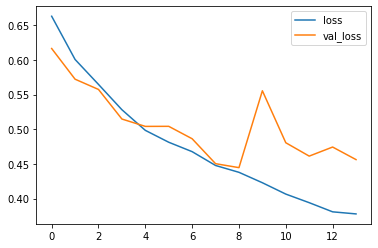

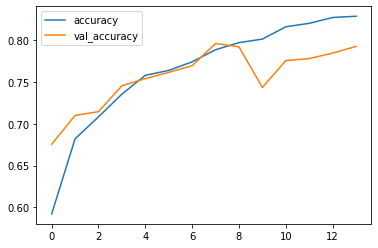

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


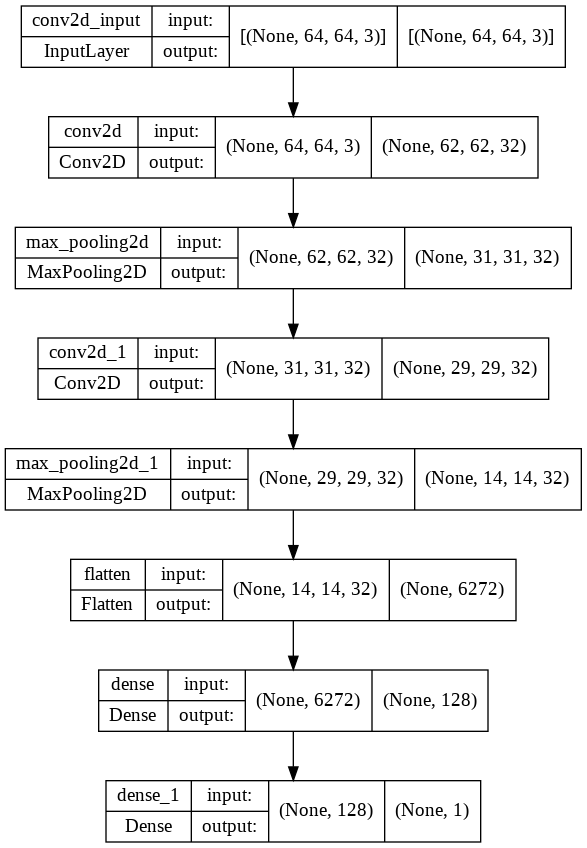

In [ ]:
plot_model(classifier, to_file='Chapter_4_CNN/Demo/model/CNN_model_20082021.png', show_shapes=True)
Image(filename='Chapter_4_CNN/Demo/model/CNN_model_20082021.png')


### **Save model**

In [ ]:
# # save model
# from tensorflow.keras.models import load_model
# # Creates a HDF5 file 'my_model_CNN_new.h5'
# classifier.save('Chapter_4_CNN/Demo/model/my_model_CNN_18052022.h5')
# print("save!!!")

In [ ]:
# from keras.models import load_model
# classifier = load_model('Chapter_4_CNN/Demo/model/my_model_CNN_18052022.h5')

### **Prediction**

In [ ]:
def print_result(test_image):
    test_image = image.img_to_array(test_image)
    print(test_image.shape)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    print(test_image.shape)
    result = classifier.predict(test_image)


    print(result)
    # 0: cat, 1: dog; sigmoid có ngưỡng 0.5
    if result[0][0]<0.5:
        prediction = 'cat'
    else:
        prediction = 'dog'
    print(prediction)


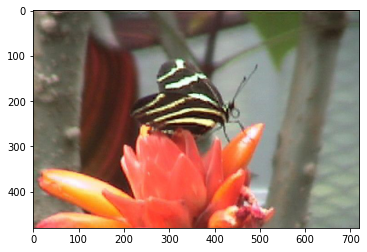

(64, 64, 3)
(1, 64, 64, 3)
[[0.99374914]]
non food


In [ ]:
import matplotlib.image as mpimg

path = 'data/data_food_non_food/evaluation/0_25.jpg'

img=mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()

# test_image = image.load_img(path, target_size = (128, 128)) # target_size = (64, 64)
test_image = image.load_img(path, target_size = (64, 64)) 
print_result(test_image)